# Simple Fractal Results
In this notebook we run a very simple river model to develop stream statistics against.  This was taken from a landlab tutorial notebook

In [1]:
from landlab import RasterModelGrid, imshow_grid
from landlab.io.esri_ascii import write_esri_ascii
from landlab.io.native_landlab import load_grid
from landlab.components import (
    ChannelProfiler,
    ChiFinder,
    FlowAccumulator,
    SteepnessFinder,
    StreamPowerEroder,
)
import numpy as np
import matplotlib.pyplot as plt
#from stream_statistician.stream_statistician import StreamStatistician
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from tqdm import tqdm
import importlib
import analysis_code as ac
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.patches import Rectangle
import matplotlib

## Model setup and run
In the below cell we set up and run the model

In [3]:
# grid stuff
number_of_rows = 1000
number_of_columns = 500
dxy = 5

K=1/5000

mg1 = RasterModelGrid((number_of_rows, number_of_columns), dxy)

mg1.set_closed_boundaries_at_grid_edges(True, True, True, False)
# setting up the model initial state
np.random.seed(30)
mg1_noise = (
    np.random.rand(mg1.number_of_nodes) / 1000.0
)

z1 = mg1.add_zeros("topographic__elevation", at="node")
z1 += mg1_noise
# time parameters of the model
tmax = 5e6  # time for the model to run [yr] (Original value was 5E5 yr)
dt = 10000  # time step [yr] (Original value was 100 yr)
total_time = 0  # amount of time the landscape has evolved [yr]
# total_time will increase as you keep running the code.

t = np.arange(0, tmax, dt)  # each of the time steps that the code will run
# other model parameters
# Original K_sp value is 1e-5
K_sp = 1.0e-5  # units vary depending on m_sp and n_sp
m_sp = 0.5  # exponent on drainage area in stream power equation
n_sp = 1.0  # exponent on slope in stream power equation
frr = FlowAccumulator(mg1, flow_director="FlowDirectorD8")  # intializing flow routing
spr = StreamPowerEroder(
    mg1, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0
)  # initializing stream power incision

theta = m_sp / n_sp
# initialize the component that will calculate channel steepness
sf = SteepnesFinder(mg1, reference_concavity=theta, min_drainage_area=1000.0)
# initialize the component that will calculate the chi index
cf = ChiFinder(
    mg1, min_drainage_area=1000.0, reference_concavity=theta, use_true_dx=True
)

#  uplift_rate [m/yr] (Original value is 0.0001 m/yr)
uplift_rate = np.ones(mg1.number_of_nodes) * 0.001

# run the model
flows = []
for ti in tqdm(t):
    z1[mg1.core_nodes] += uplift_rate[mg1.core_nodes] * dt  # uplift the landscape
    frr.run_one_step()  # route flow
    spr.run_one_step(dt)  # fluvial incision
    total_time += dt  # update time keeper
    #print(total_time)

NameError: name 'SteepnesFinder' is not defined

Here we set up a new field representing channel initiation potential, and set it equal to the product of the slope and 

In [ ]:
ci = mg1.add_zeros("channel_init", at="node", clobber=True)
ci[:] = mg1.at_node['topographic__steepest_slope']*mg1.at_node['drainage_area']

View our generated landscape, it looks relaistic .

In [ ]:
imshow_grid(
    mg1, "topographic__elevation", grid_units=("m", "m"), var_name="Elevation (m)"
)
title_text = f"$K_{{sp}}$={K_sp}; $time$={total_time} yr; $dx$={dxy} m"
plt.title(title_text)

max_elev = np.max(z1)
print("Maximum elevation is ", np.max(z1))

## Fractal Dimension,
Now we calculating the fractal dimension for 100 geometrically distributed channel threshold values, and make plots

In [112]:
fdf = ac.make_fractal_df(mg1, ['drainage_area', 'channel_init'], 100, np.geomspace)
tfdf = fdf[fdf['type']=='true']

In [113]:
dadf = tfdf[tfdf['field']=='drainage_area']
cidf = tfdf[tfdf['field']=='channel_init']

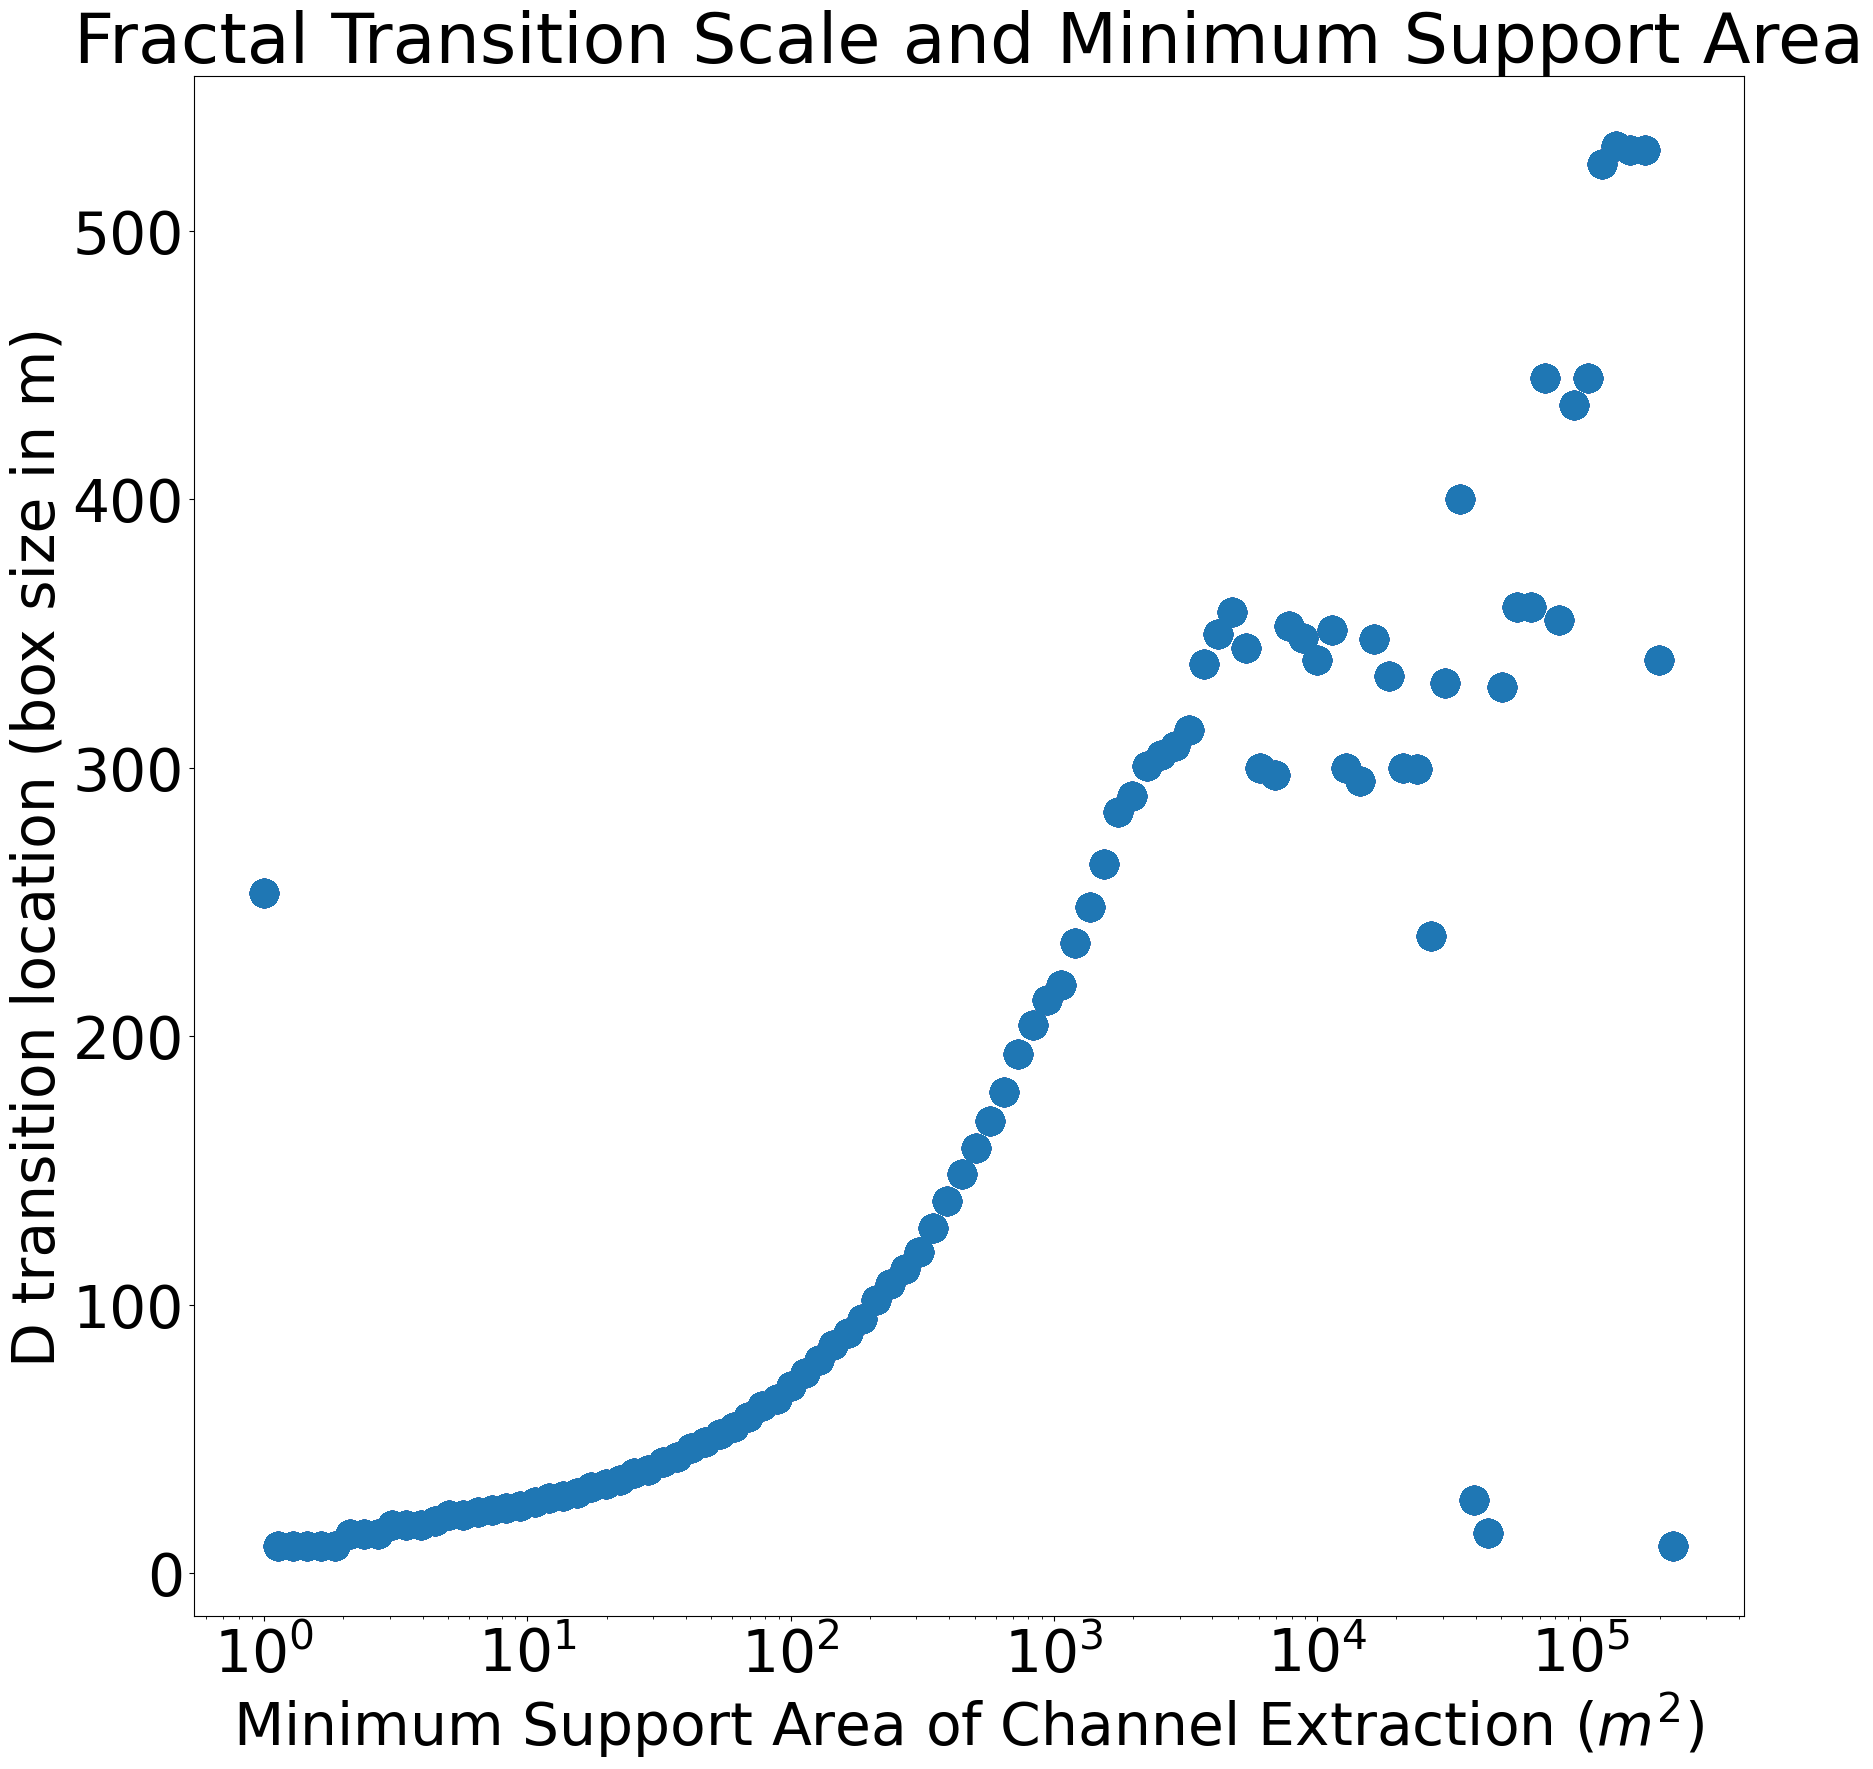

In [236]:
marker_style = dict(markersize=20,
                    markerfacecolor="tab:blue", markeredgecolor="tab:blue")
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 42}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(20,20))
ax.plot(dadf['threshold'], np.exp(dadf['t'])*5,'o', **marker_style)
ax.set_xscale('log')
ax.set_xlabel('Minimum Support Area of Channel Extraction ($m^2$)')
ax.set_ylabel('D transition location (box size in m)')
ax.set_title("Fractal Transition Scale and Minimum Support Area")
fig.savefig("transition_and_area.png")
#dath = dadf['threshold']
#plt.ylim(1.5,2)

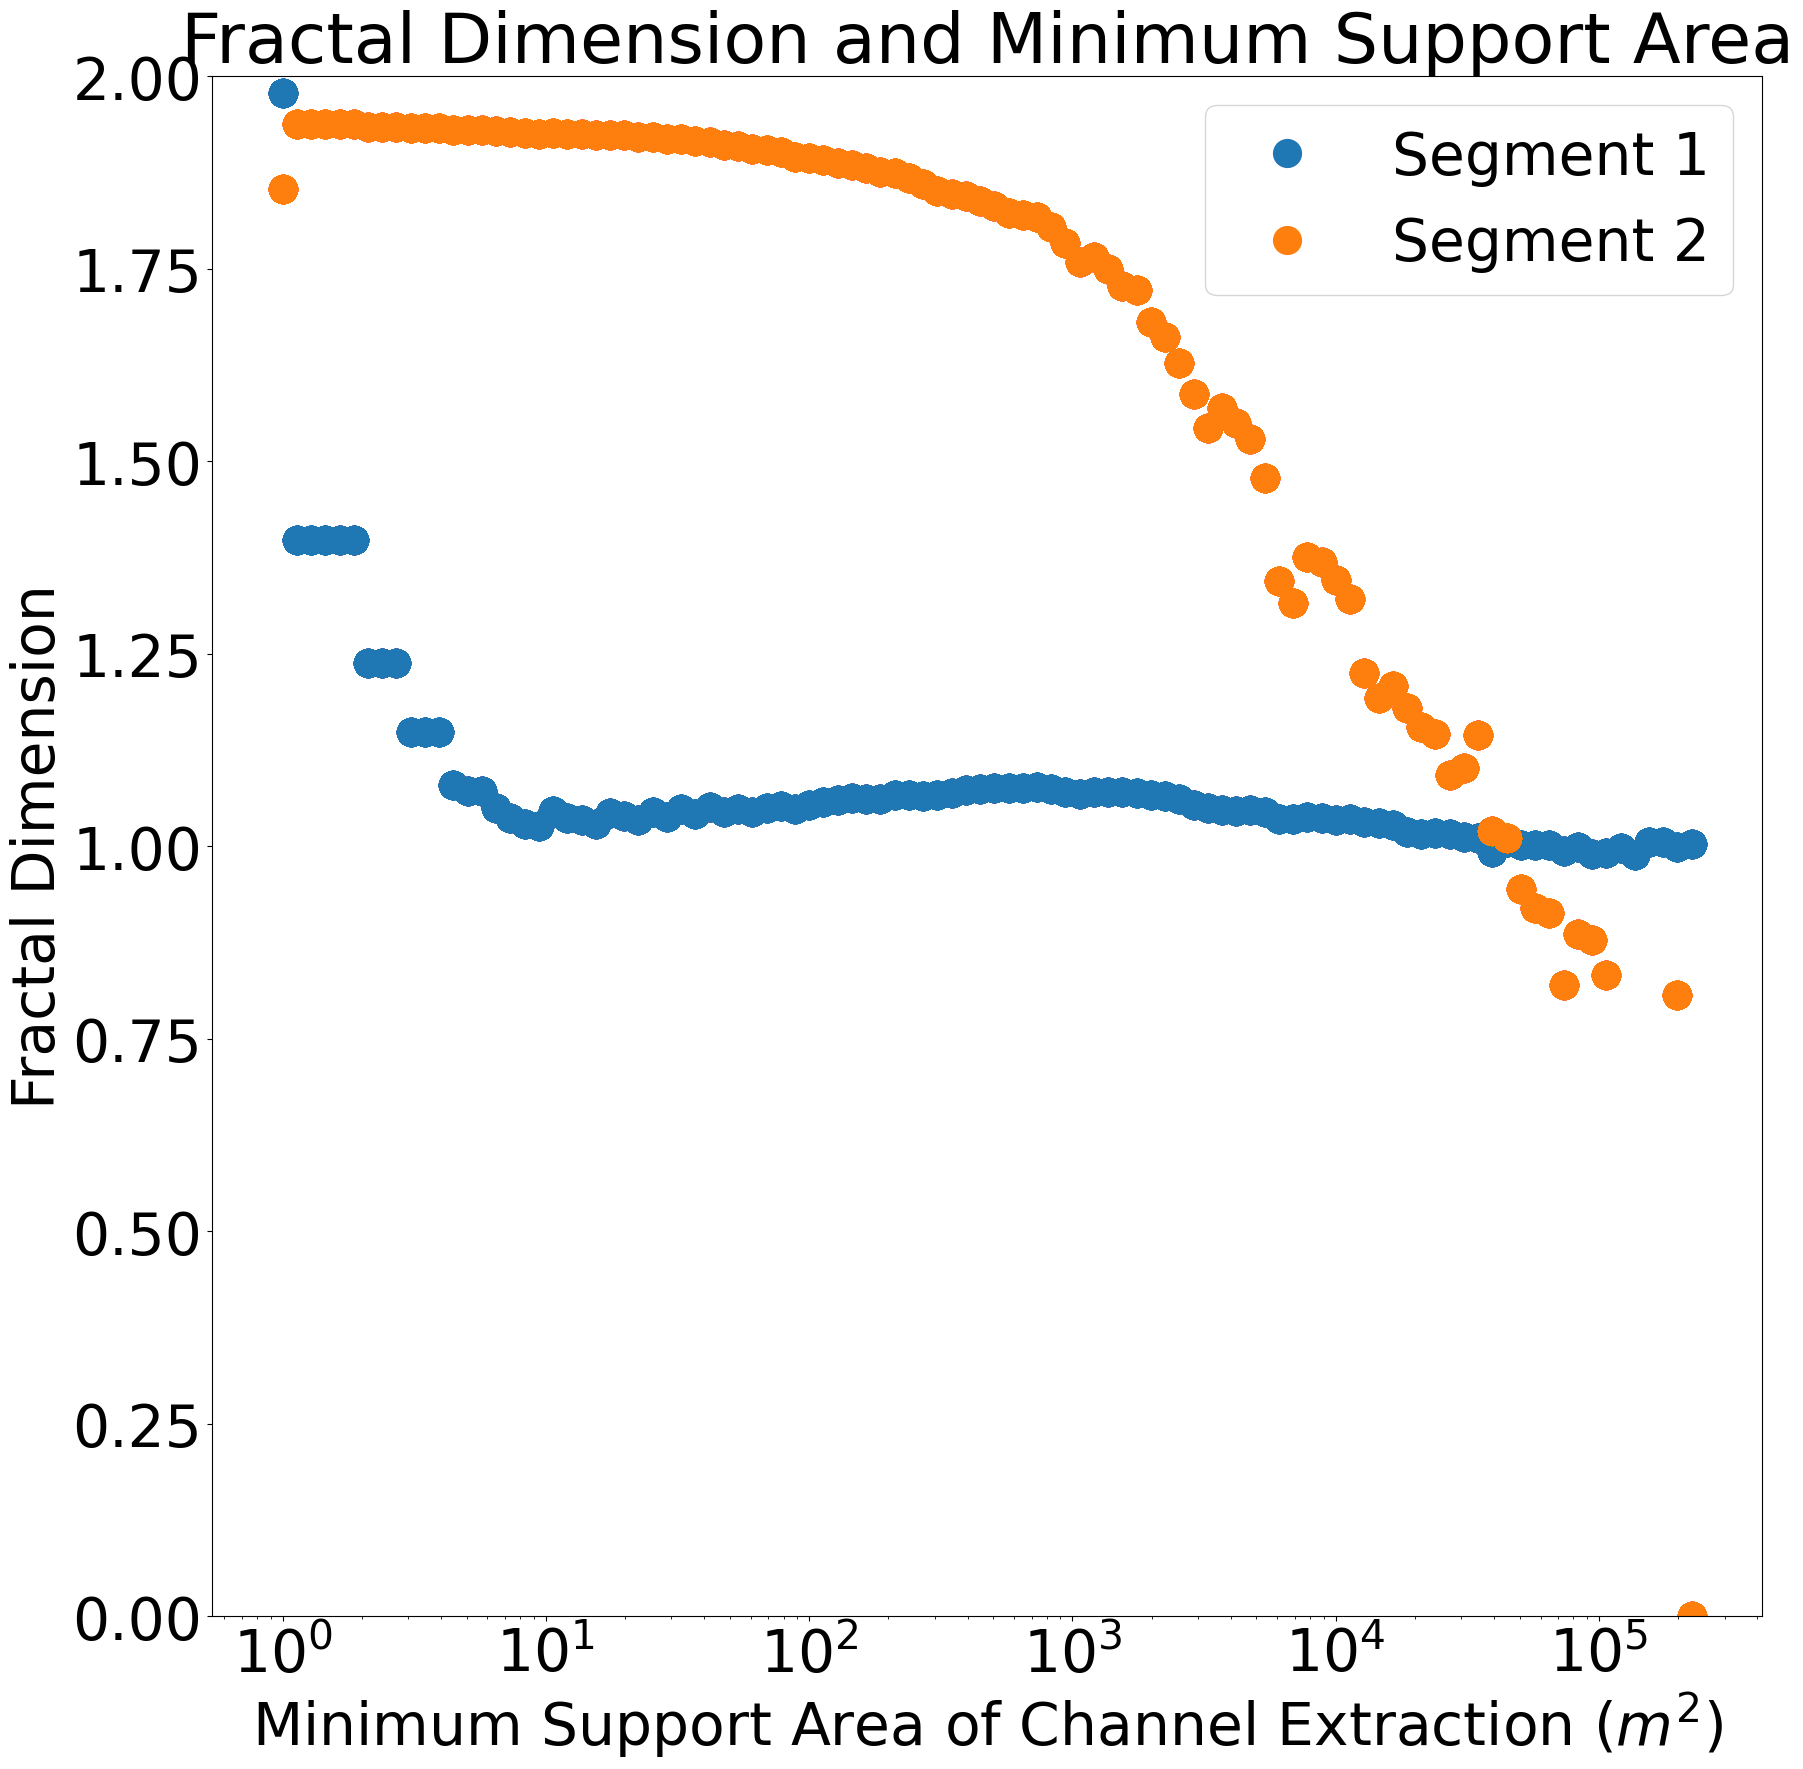

In [237]:
marker_style1 = dict(markersize=20,
                    markerfacecolor="tab:blue", markeredgecolor="tab:blue")
marker_style2 = dict(markersize=20,
                    markerfacecolor="tab:orange", markeredgecolor="tab:orange")
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 42}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(20,20))
ax.plot(dadf['threshold'], dadf['d1'],'o', label='Segment 1', **marker_style1)
ax.plot(dadf['threshold'], dadf['d2'],'o', label='Segment 2', **marker_style2)
ax.set_xscale('log')
ax.set_xlabel('Minimum Support Area of Channel Extraction ($m^2$)')
ax.set_ylabel('Fractal Dimension')
ax.set_title("Fractal Dimension and Minimum Support Area")
ax.set_ylim(0,2)
ax.legend()
fig.savefig("D_and_area.png")
#dath = dadf['threshold']
#plt.ylim(1.5,2)

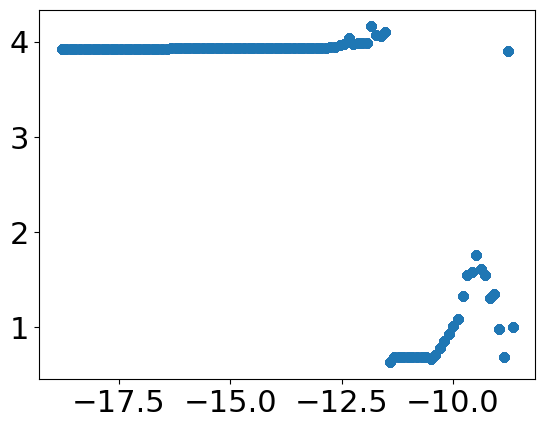

In [192]:
plt.plot(np.log(cidf['threshold']), cidf['t'],'o')
#plt.ylim(1.5,2)

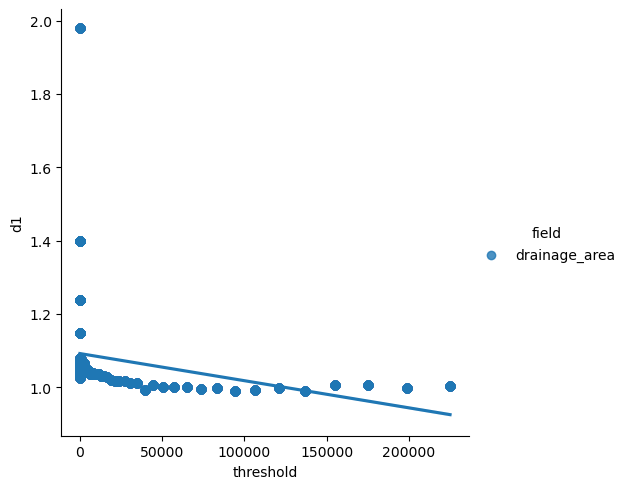

In [116]:
sns.lmplot(data=dadf, x='threshold', y='d1', hue='field')

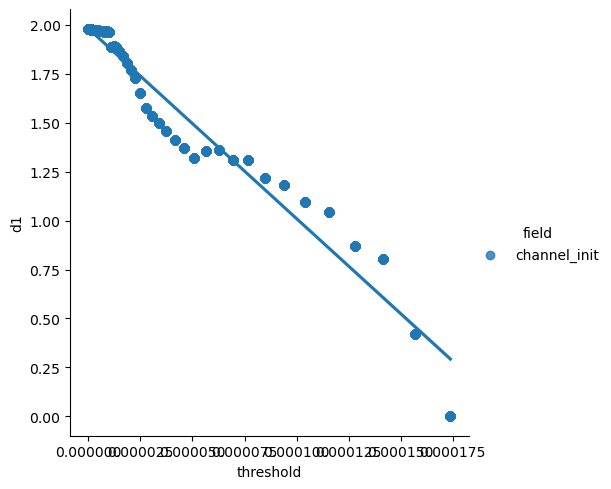

In [117]:
sns.lmplot(data=cidf, x='threshold', y='d1', hue='field')

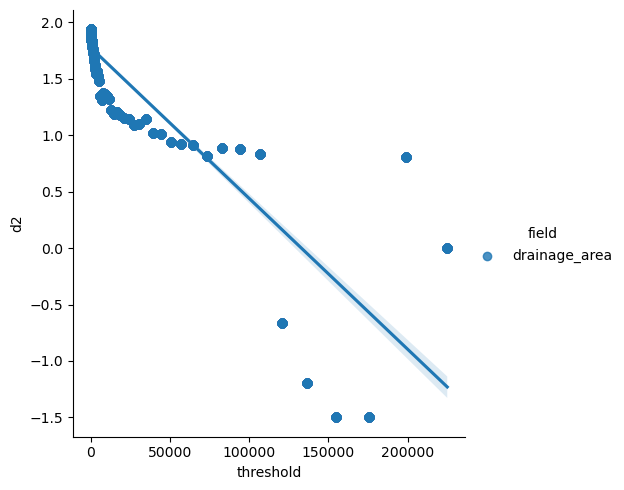

In [118]:
sns.lmplot(data=dadf, x='threshold', y='d2', hue='field')

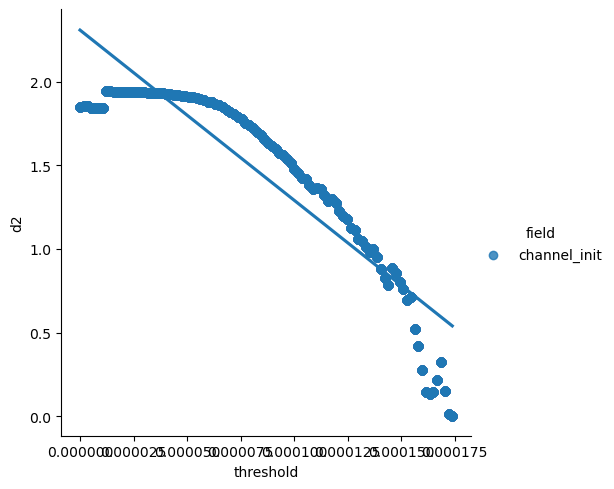

In [106]:
sns.lmplot(data=cidf, x='threshold', y='d2', hue='field')

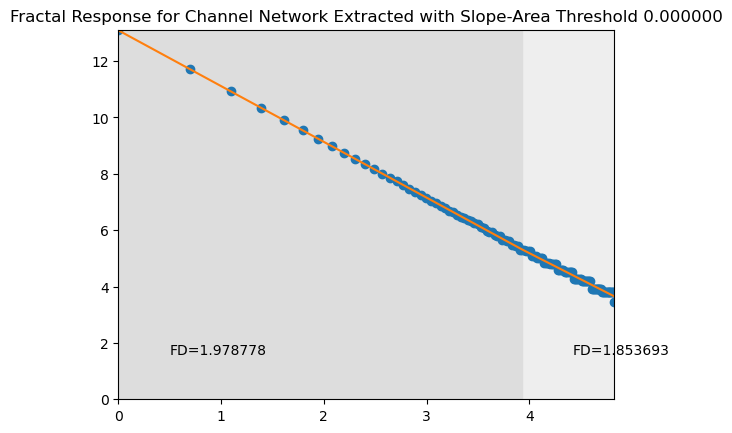

In [135]:
fig, ax = plt.subplots()
thresholds = cidf['threshold'].unique()

def plot_fractal(dataframe, threshold):
    ax.cla()
    x_min = np.log(dataframe['box size'].min())
    x_max = np.log(dataframe['box size'].max())
    y_min = np.log(dataframe['box_count'].min())
    y_max = np.log(dataframe['box_count'].max())
    working_df = dataframe[dataframe['threshold']==threshold]
    sizes = np.log(working_df['box size'])
    counts = np.log(working_df['box_count'])
    fit_x = np.linspace(0, sizes.max(), 100)
    d1s = working_df['d1'].unique()
    d2s = working_df['d2'].unique()
    ts = working_df['t'].unique()
    cs = working_df['c'].unique()
    if len(d1s)+len(d2s)+len(ts)+len(cs)>4:
        raise ValueError("Fractal fit not unique")
    fit_y = ac.multi_fractal(fit_x, d1s[0], d2s[0], cs[0], ts[0])
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(x_min, x_max)
    ax.add_patch(Rectangle((ts[0],y_min), x_max-ts[0], y_max-y_min, color='#EEEEEE'))
    ax.add_patch(Rectangle((x_min, y_min), ts[0]-x_min, y_max-y_min, color='#DDDDDD'))
    ax.text(x_min+0.5,x_max/3, "FD=%f" % d1s[0])
    ax.text(ts[0]+0.5, x_max/3, "FD=%f" % d2s[0])
    ax.plot(sizes, counts, 'o')
    ax.plot(fit_x, fit_y)
    ax.set_title("Fractal Response for Channel Network Extracted with Slope-Area Threshold %f" % threshold)

plotter = lambda i: plot_fractal(cidf, thresholds[i])
anim = FuncAnimation(fig, plotter, len(thresholds))
vid = HTML(anim.to_jshtml())
vid

In [238]:
#fig, ax = plt.subplots()
thresholds = dadf['threshold'].unique()
marker_style = dict(linestyle=':', color='0.8', markersize=20,
                    markerfacecolor="tab:blue", markeredgecolor="tab:blue")
line_style = dict(linestyle='-', color='orange', markersize=20,
                    markerfacecolor="orange", markeredgecolor="orange", linewidth=5)
def plot_fractal(dataframe, threshold):
    ax.cla()
    x_min = np.log(dataframe['box size'].min())
    x_max = np.log(dataframe['box size'].max())
    y_min = np.log(dataframe['box_count'].min())
    y_max = np.log(dataframe['box_count'].max())
    working_df = dataframe[dataframe['threshold']==threshold]
    sizes = np.log(working_df['box size'])
    counts = np.log(working_df['box_count'])
    fit_x = np.linspace(0, sizes.max(), 100)
    d1s = working_df['d1'].unique()
    d2s = working_df['d2'].unique()
    ts = working_df['t'].unique()
    cs = working_df['c'].unique()
    if len(d1s)+len(d2s)+len(ts)+len(cs)>4:
        raise ValueError("Fractal fit not unique")
    fit_y = ac.multi_fractal(fit_x, d1s[0], d2s[0], cs[0], ts[0])
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(x_min, x_max)
    ax.add_patch(Rectangle((ts[0],y_min), x_max-ts[0], y_max-y_min, color='#EEEEEE'))
    ax.add_patch(Rectangle((x_min, y_min), ts[0]-x_min, y_max-y_min, color='#DDDDDD'))
    ax.text(x_min+0.5,x_max/3, "D=%f" % d1s[0])
    ax.text(ts[0], x_max/3, "D=%f" % d2s[0])
    ax.plot(sizes, counts, 'o', **marker_style)
    ax.plot(fit_x, fit_y, **line_style)
    ax.set_title("Fractal Response for Channel Network Extracted with Area Threshold %f" % threshold)

#plotter = lambda i: plot_fractal(dadf, thresholds[i])
#anim = FuncAnimation(fig, plotter, len(thresholds))
#vid = HTML(anim.to_jshtml())
#vid

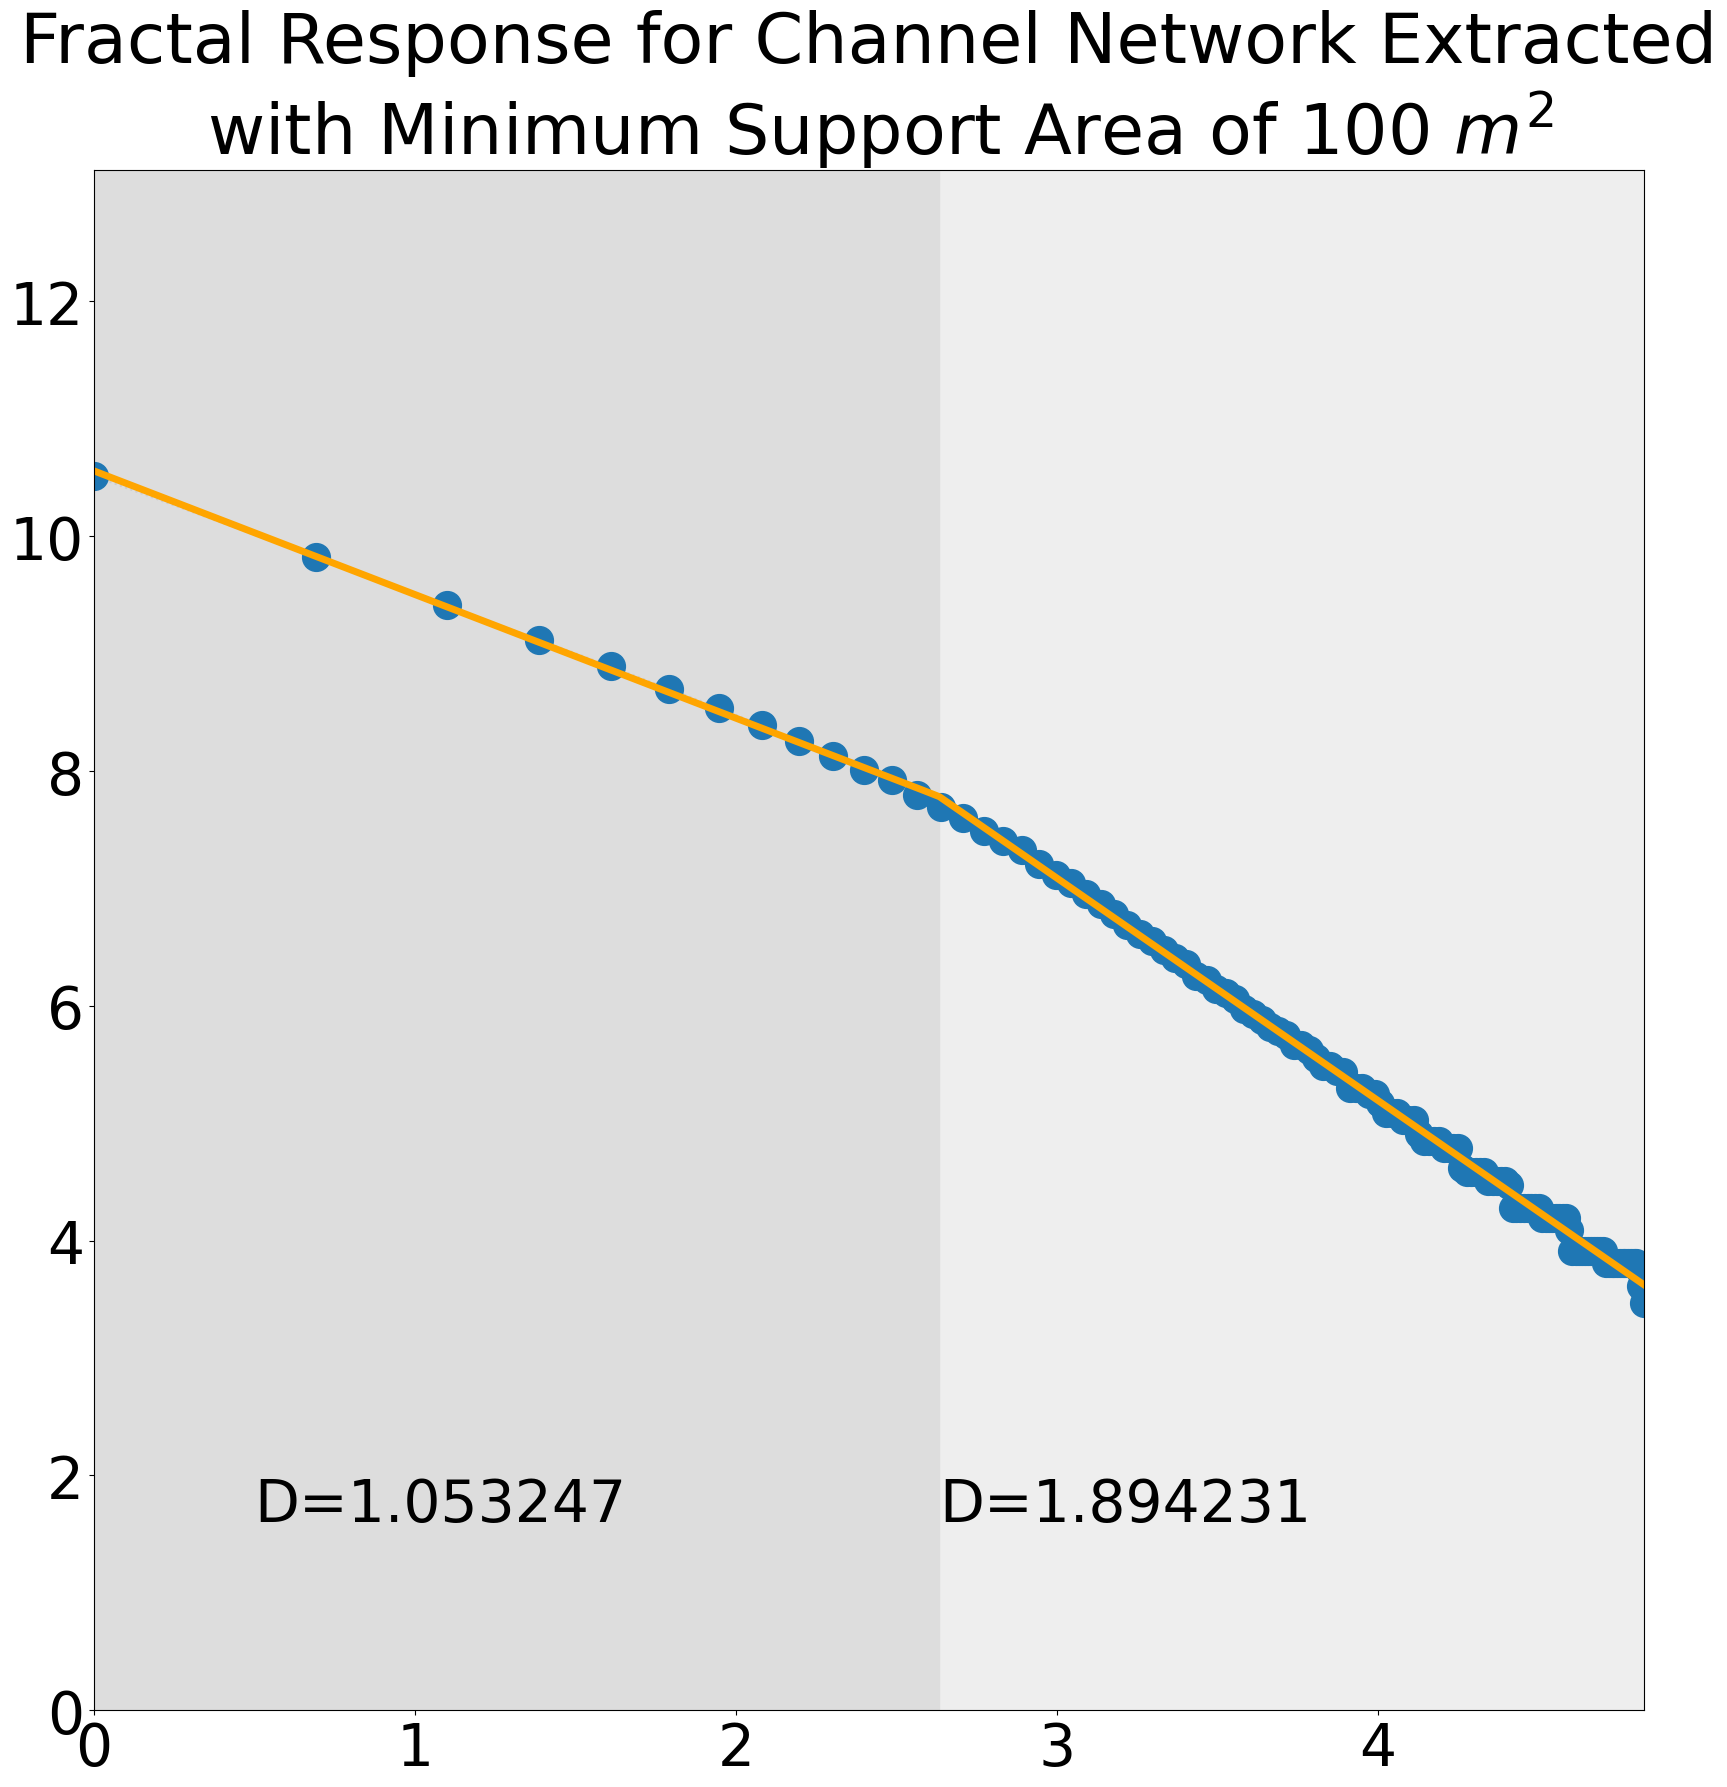

In [241]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 42}
thresholds = dadf['threshold'].unique()

matplotlib.rc('font', **font)
#matplotlib.rc('marker', **marker_style)
fig, ax = plt.subplots(figsize=(20,20))
plot_fractal(dadf, thresholds[37])
ax.set_title("Fractal Response for Channel Network Extracted\n with Minimum Support Area of 100 $m^2$")
fig.savefig('area_fractal.png')

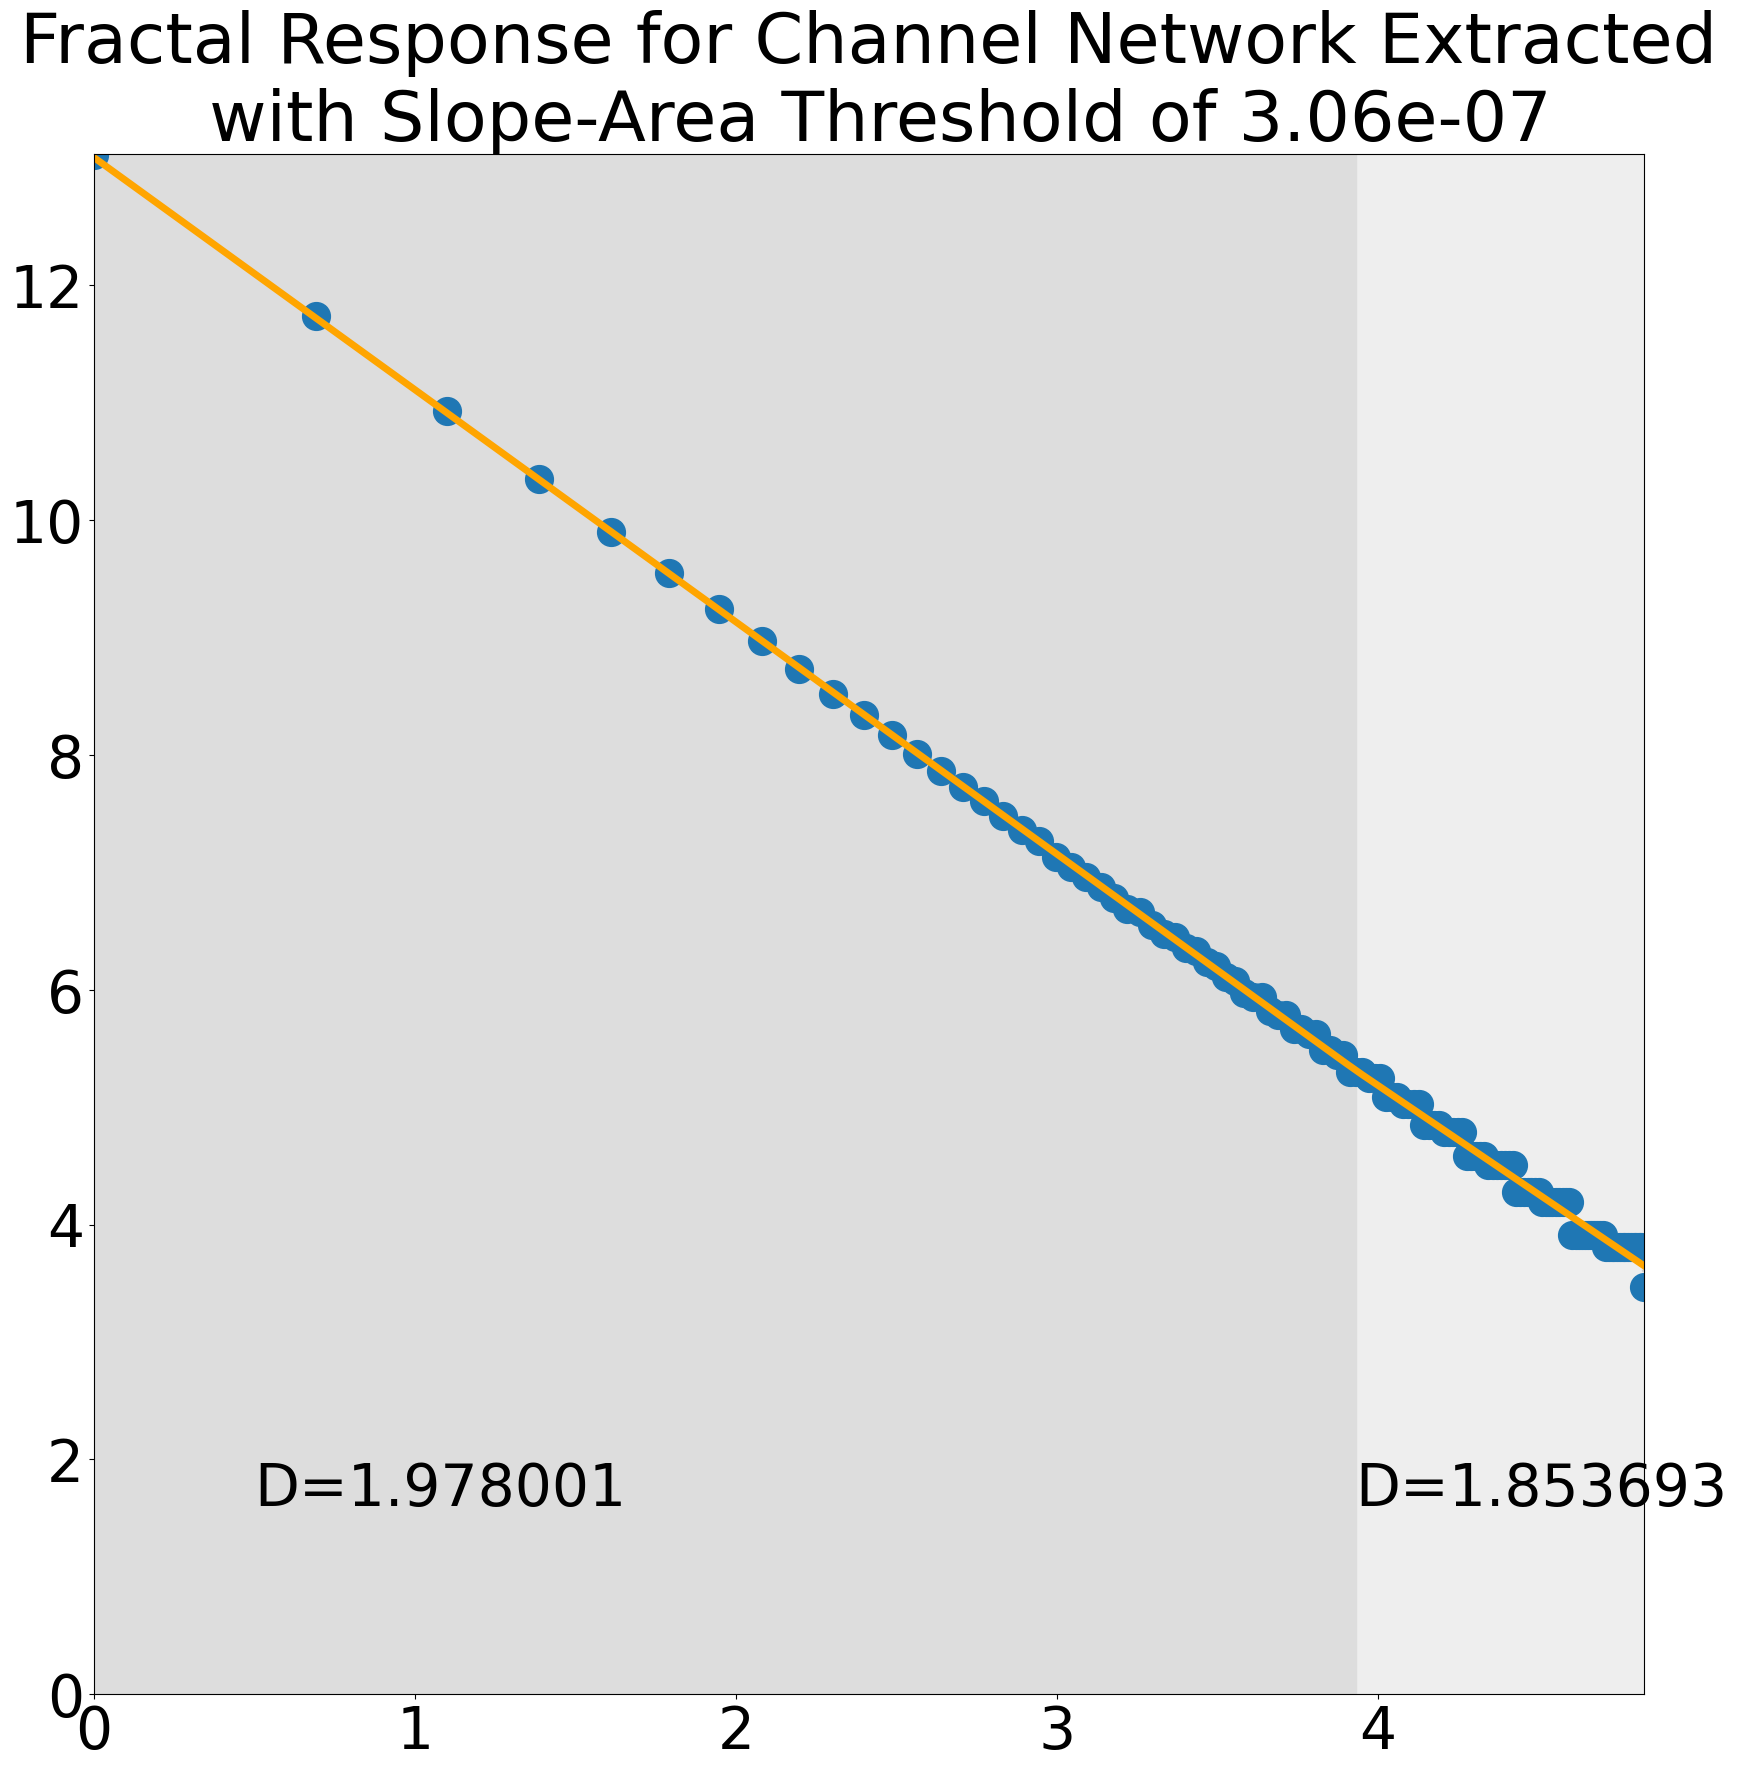

In [242]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 42}
thresholds = cidf['threshold'].unique()
matplotlib.rc('font', **font)
#matplotlib.rc('marker', **marker_style)
fig, ax = plt.subplots(figsize=(20,20))
plot_fractal(cidf, thresholds[37])
ax.set_title("Fractal Response for Channel Network Extracted\n with Slope-Area Threshold of %.2e" % thresholds[37])
fig.savefig('slopearea_fractal.png')

In [183]:
thresholds[37]

3.0601828803486416e-07